In [1]:
import warnings

# The workhorses
import pandas as pd
import numpy as np
# Our main MCMC package
import emcee
import collections
import scipy.stats as st

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load data
df = pd.read_csv('data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

In [3]:
wt = df[df['genotype']=='wt']['mean_rest_bout_length']
mut = df[df['genotype']=='mut']['mean_rest_bout_length']

## Problem 5.1a Frequentist parameter estimation

We are assuming that both the wild-type and mutant bout-lengths have Gaussian distributions and want unbiased estimators for $\mu_i$ and $\sigma_i^2$, where $i \in \{w,m\}$. These are, respectively, the sample mean:
$$\bar{x_i} = \frac{1}{n_i}\sum_{x_j \in i} x_j$$
and the sample variance:
$$s_i^ 2 = \frac{1}{n_i-1}\sum_{x_j \in i} (x_j - \bar{x_i})^ 2$$

We will use the built-in functions in Pandas to calculate these. 

In [4]:
x_bar_w = wt.mean()
x_bar_m = mut.mean()
var_w = wt.var(ddof=1)
var_m = mut.var(ddof=1)
n_wt = len(wt)
n_mut = len(mut)
print ('            mean (min)   variance (min²)    n')
print ('wild-type:  %.3f        %.3f             %d' %(x_bar_w, var_w, n_wt))
print ('mutant:     %.3f        %.3f             %d' %(x_bar_m, var_m, n_mut))

            mean (min)   variance (min²)    n
wild-type:  2.209        0.273             17
mutant:     1.727        0.648             22


We also want to calculate Cohen's d as an estimate of the effect size. 

In [5]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

actual_d = cohen_d (wt,mut)

print ("Cohen's d = %.4f" %actual_d)

Cohen's d = -0.6927


## Problem 5.1b Frequentist estimation of the difference

Let's do this by bootstrapping. First, let's make a function that draws bootstrap samples and uses them to estimate some parameter. 

In [6]:
def bootstrap_estimate (x, n, param_fun, args=(), replicates=1000):
    """Estimates a parameter by drawing bootstrap samples of x. """
    return np.array([param_fun(np.random.choice(x, n, replace=True)) \
            for r in range(replicates)])

Now, let's use this function to calculate $\delta = \bar{x_w} - \bar{x_m}$ for 1000 bootstrap samples. 

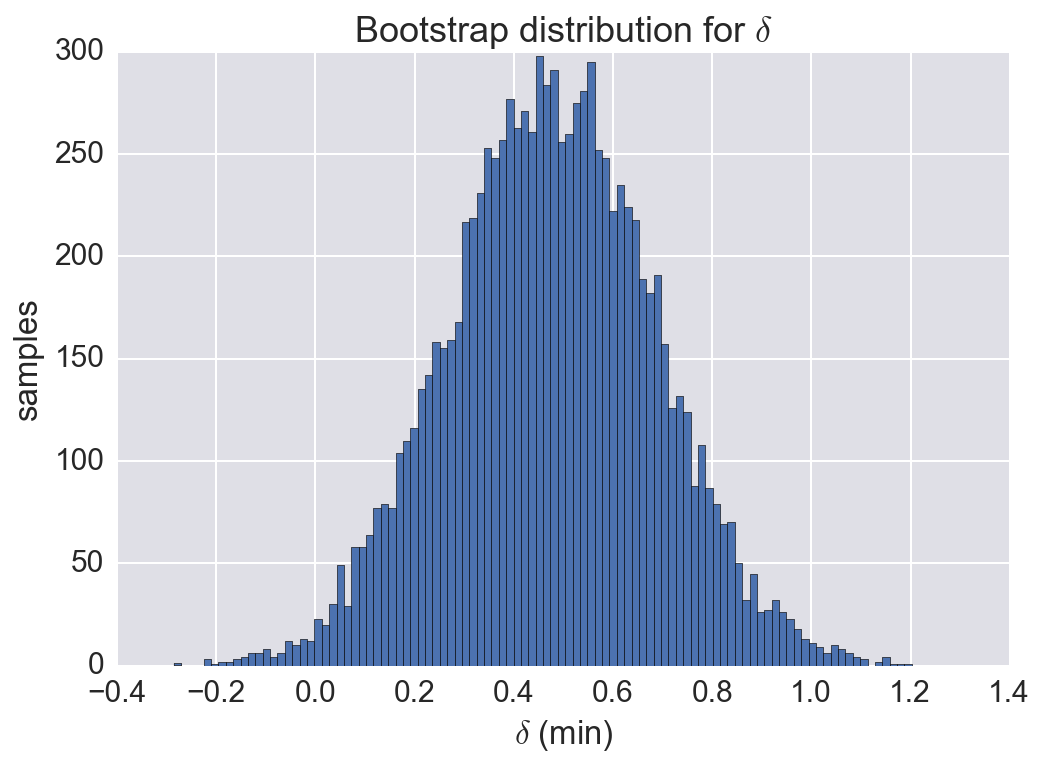

In [7]:
deltas = bootstrap_estimate (wt, n_wt, np.mean, replicates=10000) \
- bootstrap_estimate(mut, n_mut, np.mean, replicates=10000)
_ = plt.hist(deltas, bins=100)
plt.xlabel ('$\delta$ (min)')
plt.ylabel ('samples')
plt.title ('Bootstrap distribution for $\delta$')

That looks Gaussian enough that we can use the mean as the best estimate. We'll use the 2.5th and 97.5th percentiles to get a 95% confidence interval. 

In [8]:
delta_bar = np.mean(deltas)
CI = tuple(np.percentile (deltas, (2.5, 97.5)))
print ('The mean bootstrap value for delta is %.4f minutes.' % delta_bar)
print ('The 95%% confidence interval for delta is (%.4f,%.4f) minutes.' %CI)

The mean bootstrap value for delta is 0.4751 minutes.
The 95% confidence interval for delta is (0.0742,0.8840) minutes.


# Problem 5.1 c

In [9]:
mut_inds = df['genotype'] == 'mut'
wt_inds = df['genotype'] == 'wt'

df_mut = df[mut_inds]
df_wt = df[wt_inds]

wt_rest = df_wt['mean_rest_bout_length']
mut_rest = df_mut['mean_rest_bout_length']

In [10]:
def log_post(p, x_1, x_2):
    """
    p[0] = mu_wt
    p[1] = mu_mut
    p[2] = sigma_wt
    p[3] = sigma_mut
    """
    # Unpack parameters
    mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
    # Make sure we have everything in the right range
    if (sigma_wt < 0) or (sigma_mut < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_1 = st.norm.logpdf(x_1, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    log_post_2 = st.norm.logpdf(x_2, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

    # Add them up to return
    return log_post_1 + log_post_2

In [11]:
params = collections.OrderedDict([('mu_wt', (np.random.uniform, (0, 5))),
                                  ('mu_mut', (np.random.uniform, (0, 5))),
                                  ('sigma_wt', (np.random.exponential, (0.1,))),
                                  ('sigma_mut', (np.random.exponential, (0.1,)))])


n_dim = 4        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 1000     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in


p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0,5, n_walkers)
p0[:,1] = np.random.uniform(0,5, n_walkers)    
p0[:,2] = np.random.exponential(.1, n_walkers)    
p0[:,3] = np.random.exponential(.1, n_walkers) 


sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                args=(wt_rest, mut_rest), threads=4)

In [12]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [13]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [14]:
# Get the index of the most probable parameter set

max_ind = np.argmax(sampler.flatlnprobability)

#sampler.flatlnprobability
# Pull out values.
mu_wt_MAP, mu_mut_MAP, sigma_wt_MAP, sigma_mut_MAP = sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
Wt:   {0:.3f} +/- {2:.3f}
Mut:  {1:.3f} +/- {3:.3f}
""".format(mu_wt_MAP, mu_mut_MAP, sigma_wt_MAP, sigma_mut_MAP))


Most probable parameter values:
Wt:   2.208 +/- 0.498
Mut:  1.731 +/- 0.769



In [15]:
# If we assume that the measurments are independent, than the difference delta can be expressed as follows
# delta_MAP = mu_wt_MAP - mu_mut_MAP
# sigma_delta_MAP = np.sqrt((sigma_wt_MAP**2)+(sigma_mut_MAP**2))

delta_MAP = mu_wt_MAP - mu_mut_MAP
sigma_delta_MAP = np.sqrt((sigma_wt_MAP**2)+(sigma_mut_MAP**2))

# Print the results
print("""
Most probable parameter values:
δ:   {0:.3f} +/- {1:.3f}
""".format(delta_MAP, sigma_delta_MAP))


Most probable parameter values:
δ:   0.477 +/- 0.916



In [18]:
cov_1 = np.cov(sampler.flatchain.T)

## Problem 5.1d Hypothesis testing
Let $H_0$ be that the wild-type and mutant sleep bout lengths were sampled from the same Gaussian distribution. We want to know the probability of getting a difference between the sample means that is at least as great as the difference between our sample means. To do that, we will combine all of our measurements into one pool, then draw bootstrap samples for wild-type and mutant from that combined pool. 

We'll also plot a histogram of the sample differences and highlight the ones that are greater than or equal to the actual difference. 

In [19]:
combined = pd.concat([wt, mut])

diffs = bootstrap_estimate (combined, n_wt, np.mean, replicates=10000) \
- bootstrap_estimate(mut, n_mut, np.mean, replicates=10000)

In [20]:
actual_diff = x_bar_w - x_bar_m
p_value = sum(d >= actual_diff for d in diffs)/len(diffs)
print ('p = %.4f' %p_value)

p = 0.1313


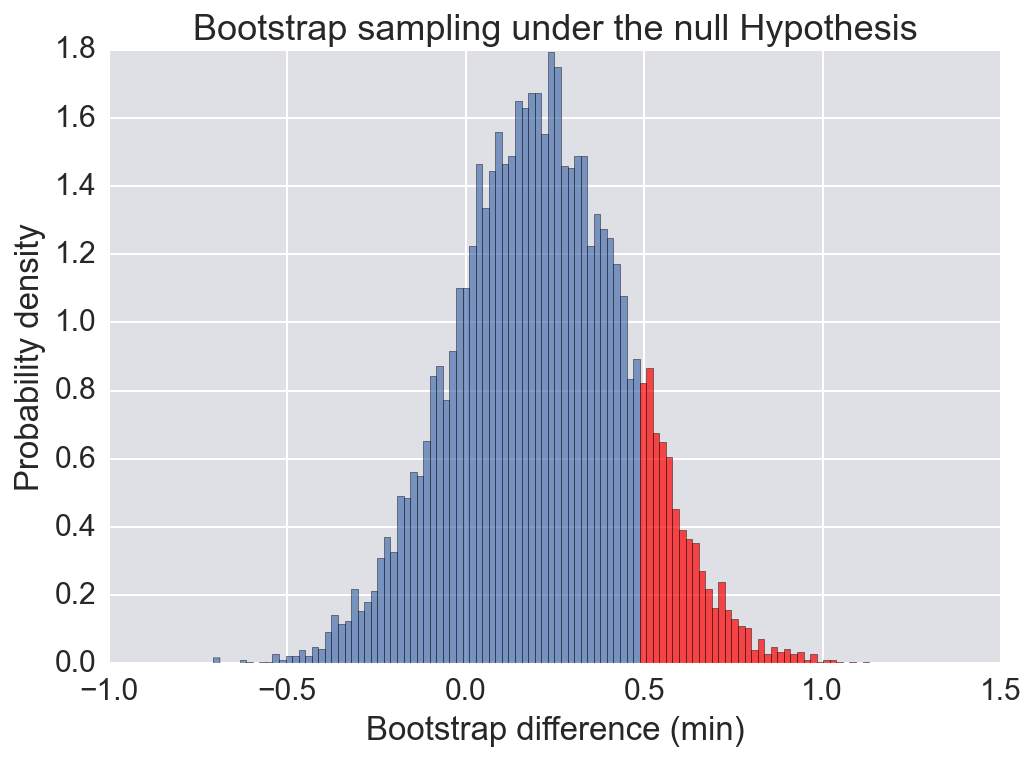

In [21]:
n, bins, patches = plt.hist(diffs, bins=100, normed=True, alpha=0.7)
for b, p in zip (bins, patches):
    if b < actual_diff:
        continue
    plt.setp(p, 'facecolor', 'red', alpha=0.7)
plt.xlabel ('Bootstrap difference (min)')
plt.ylabel ('Probability density')
plt.title ('Bootstrap sampling under the null Hypothesis')


# 5e
We already have the MAPs and covariance matrix from part c (H1), and it's called cov_1
Now we should calculate the MAPs and covariance matrix for H0

In [23]:
def log_post_0(p, x_0):
    """
    p[0] = mu_0
    p[1] = sigma_0
    """
    # Unpack parameters
    mu_0, sigma_0= p
    
    # Make sure we have everything in the right range
    if (sigma_0 < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_0 = st.norm.logpdf(x_0, mu_0, sigma_0).sum() - np.log(sigma_0)

    # Add them up to return
    return log_post_0

In [25]:
rest = df['mean_rest_bout_length']
params = collections.OrderedDict([('mu_0', (np.random.uniform, (0, 5))),
                                  ('sigma_0', (np.random.exponential, (0.1,)))])

n_dim = 2        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 1000     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in


p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0,5, n_walkers)  
p0[:,1] = np.random.exponential(.1, n_walkers)    


sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_0, 
                                args=(rest,), threads=4)

In [26]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [27]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [28]:
# Get the index of the most probable parameter set

max_ind = np.argmax(sampler.flatlnprobability)

#sampler.flatlnprobability
# Pull out values.
mu_0_MAP, sigma_0_MAP= sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
Overall:   {0:.3f} +/- {1:.3f}
""".format(mu_0_MAP, sigma_0_MAP))


Most probable parameter values:
Overall:   1.937 +/- 0.711



In [29]:
cov_0 = np.cov(sampler.flatchain.T)